In [1]:
%load_ext autoreload
%autoreload 2

# Verification of MINA routines against D717A weld from Moysan (2003)
This notebook compares the outputs of:
* mina-weld package
* David Fan's MATLAB implementation of MINA from NDE Lab repository
* the image from Moysan (2003).

Some identified issues include:
* Moysan (2003) does not specify the number of passes per layer explicitly. They may only be inferred from Fig 2., but this is prone to error.
* The height of the top parabola is also not given.
* David Fan's code does not use the double-parabolic shape of the pass - it seems that rectangles are used instead.

In [13]:
"""
A test validating mina-weld against Moysan et al. (2003), case D717A
Created by: Michal K. Kalkowski
20/02/2018

License: MIT
"""
import numpy as np
import matplotlib.pyplot as plt
import mina.mina_model as mina

# Create weld model
weld_parameters = dict([('remelt_h', 0.47),
                        ('remelt_v', 0.26),
                        ('theta_b', np.deg2rad(18)),
                        ('theta_c', np.deg2rad(12)),
                        ('order', 'left_to_right'),
                        ('number_of_layers', 11),
                        ('number_of_passes', np.array([1]*1 + 4*[2] + 2*[3] +
                                                      [4]*4)),
                        ('electrode_diameter', np.array([1.6, 2.5, 3.2, 4] +
                                                        [5]*4 + [4]*3)),
                        ('a', 38),
                        ('b', 4),
                        ('c', 36)])
weld = mina.MINA_weld(weld_parameters)
weld.define_grid_size(2., use_centroids=True)
weld.h_top = 0.2
weld.solve()
# weld.fill_missing()


------MINA model setup------
Horizontal remelting rate: 0.47
Vertical remelting rate: 0.26
theta_b and theta_c: 0.3141592653589793 and 0.20943951023931956
Order of passes: left_to_right
Number of layers: 11
Number of passes: [1 2 2 2 2 3 3 4 4 4 4]
Electrode diameter: [1.6 2.5 3.2 4.  5.  5.  5.  5.  4.  4.  4. ]
Weld thickness: 38
Chamfer base: 4
Chamfer top: 36
----------------------------


## Grid element centroid based

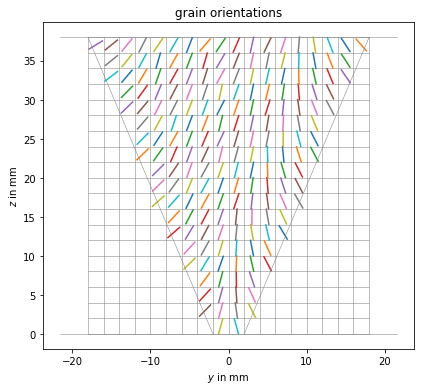

In [21]:
weld.define_grid_size(2., use_centroids=True)
weld.h_top = 0.2
weld.solve()
weld.plot_grain_orientations(grid=True)

## Nodes based

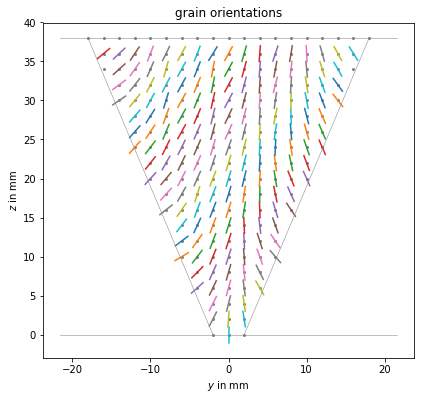

In [22]:
weld.define_grid_size(2., use_centroids=False)
weld.solve()
weld.plot_grain_orientations(grid=True)

## David Fan's code

![](../references/D_Fan_MATLAB_prediction_Moysan_2003.png)

## Original - Moysan (2003)
![alt](../references/Moysan_2003.png)


## Observations:
* weld root is supposed to be 4 mm For a 2 mm grid, the figure from  Moysan (2003) indicates the weld root of 6 mm (four orientation lines are present)
* I assume that both Davif Fan and Moysan (2003) use a 'nodes-based' approach, seed the domain with nodes and calculate the orientations for these points. My preferred approach is based on centroids - I treat the resulting grid as a set of elements, rather than a set of nodes. There is no meaningful difference, I believe. My approach is just more appealing;)
* 